In [140]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [141]:
# Constants

X_MIN, X_MAX, Y_MIN, Y_MAX = 0, 10, 0, 10
obs_dim = 10
state_dim = 2

# Centroids
centroids = []
for x in (X_MAX//4, X_MAX * 3//4):
    for y in (Y_MAX//4, Y_MAX * 3//4):
        centroids.append(np.array((x, y)))

rooms = []
for x in (X_MAX//2, X_MAX):
    for y in (Y_MAX//2, Y_MAX):
        rooms.append((x-X_MAX//2, y-Y_MAX//2, x, y))
def initiation_set(room_limits):
    def _init(state):
        low_limit = room_limits[0:2]
        high_limit = room_limits[2:]
        return not (state[0] > low_limit[0] and state[0] < high_limit[0] and state[1] > low_limit[1] and state[1] < high_limit[1])
    return _init
# Synthetic option definition

effect_dists_params = []
initiation_sets = []
std_dev = 1
for i, room in enumerate(rooms):
    initiation_sets.append(initiation_set(room))
    effect_dists_params.append((centroids[i], std_dev))

In [142]:
# Data Generation

N = 1000

x = np.random.uniform(0, X_MAX, N)
y = np.random.uniform(0, Y_MAX, N)

s = np.array((x,y)).T

masks = []
for i, init_set in enumerate(initiation_sets):
    mask = np.zeros((N,1))
    for j in range(N):
        mask[j] = float(init_set(s[j]))
    masks.append(mask)

masks = np.array(masks)
I_s = np.array(masks).transpose((1,0,2))[...,0] # initiation vector at s

# generate next states
s_prime = []
for i, effect_dist in enumerate(effect_dists_params):
    s_prime.append(np.random.multivariate_normal(effect_dist[0], effect_dist[1] * np.eye(2), size=N))


s_prime = np.array(s_prime) * masks  + s[np.newaxis] * (1-masks)
masks = masks.reshape((-1,))

I_s_prime = []
for action in range(len(initiation_sets)):
    _m = np.zeros((N,len(initiation_sets)))
    for i, init_set in enumerate(initiation_sets):
        for j in range(N):
            _m[j, i] = float(init_set(s_prime[action][j]))
    I_s_prime.append(_m)

# Random affine transformation

T = np.random.rand(obs_dim, state_dim)
x = np.einsum('ij, kj->ki', T, s)
x_prime = np.einsum('ij, lkj->lki', T, s_prime)

data = []
for i in range(len(effect_dists_params)):
    data.append((x, x_prime[i], I_s, I_s_prime[i], s, s_prime[i]))

In [143]:
# Constants

X_MIN, X_MAX, Y_MIN, Y_MAX = 0, 10, 0, 10
obs_dim = 10
state_dim = 2

# Centroids
centroids = []
for x in (X_MAX//4, X_MAX * 3//4):
    for y in (Y_MAX//4, Y_MAX * 3//4):
        centroids.append(np.array((x, y)))

rooms = []
for x in (X_MAX//2, X_MAX):
    for y in (Y_MAX//2, Y_MAX):
        rooms.append((x-X_MAX//2, y-Y_MAX//2, x, y))
def initiation_set(room_limits):
    def _init(state):
        low_limit = room_limits[0:2]
        high_limit = room_limits[2:]
        return not (state[0] > low_limit[0] and state[0] < high_limit[0] and state[1] > low_limit[1] and state[1] < high_limit[1])
    return _init
# Synthetic option definition

effect_dists_params = []
initiation_sets = []
std_dev = 1
for i, room in enumerate(rooms):
    initiation_sets.append(initiation_set(room))
    effect_dists_params.append((centroids[i], std_dev))

In [144]:
# Constants

X_MIN, X_MAX, Y_MIN, Y_MAX = 0, 10, 0, 10
obs_dim = 10
state_dim = 2

# Centroids
centroids = []
for x in (X_MAX//4, X_MAX * 3//4):
    for y in (Y_MAX//4, Y_MAX * 3//4):
        centroids.append(np.array((x, y)))

rooms = []
for x in (X_MAX//2, X_MAX):
    for y in (Y_MAX//2, Y_MAX):
        rooms.append((x-X_MAX//2, y-Y_MAX//2, x, y))
def initiation_set(room_limits):
    def _init(state):
        low_limit = room_limits[0:2]
        high_limit = room_limits[2:]
        return not (state[0] > low_limit[0] and state[0] < high_limit[0] and state[1] > low_limit[1] and state[1] < high_limit[1])
    return _init
# Synthetic option definition

effect_dists_params = []
initiation_sets = []
std_dev = 1
for i, room in enumerate(rooms):
    initiation_sets.append(initiation_set(room))
    effect_dists_params.append((centroids[i], std_dev))

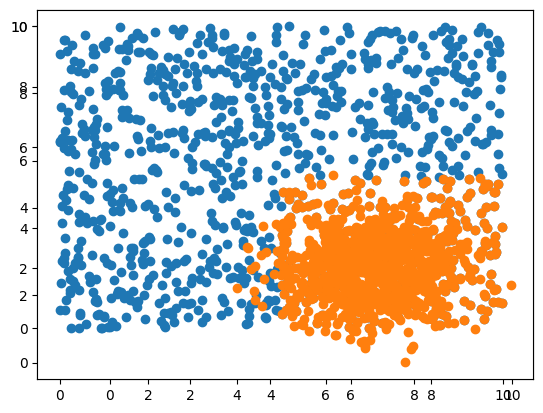

In [145]:
#Plot to Check
for r in range(1,3):
    ax = plt.axes()    
    ax.scatter(s[:, 0], s[:, 1])
    ax.scatter(s_prime[r,:,0], s_prime[r,:,1])

In [146]:
# Models
n_actions = 4
hidden_size = 64
latent_dim = 2

def init_models():
    encoder = nn.Sequential(
                                nn.Linear(obs_dim, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, latent_dim + 1)
                        )

    transition_model = nn.Sequential(
                                    nn.Linear(latent_dim + n_actions, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, latent_dim + 1)
                                )

    grounding_model = nn.Sequential(
                                    nn.Linear(latent_dim, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, obs_dim + 1)
                                )
    
    initiation_classifier = nn.Sequential(
                                    nn.Linear(latent_dim, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, n_actions),
                                    nn.Sigmoid()
                                )
    return encoder, transition_model, grounding_model, initiation_classifier

encoder, transition_model, grounding_model, initiation_classifier = init_models()

In [147]:
### Training hyperparameters
n_epochs = 100
minibatch_size = 32
n_samples = 1  # samples to approximate expectation
learning_rate = 1e-4
beta = 0.001  # hyperparameter to control information bottleneck


In [148]:
# Cast data to float torch tensor and add action one-hot encoding
in_data = []
out_data = []
initiations_s = []
initiations_s_prime = []
for i in range(n_actions):
    data[i] = [torch.from_numpy(_tensor).float() for _tensor in data[i]]
    actions = nn.functional.one_hot(torch.ones(data[i][0].size(0)).long() * i, n_actions)
    data[i] = (torch.cat((data[i][0], actions), dim=1), data[i][1], data[i][2], data[i][3], data[i][4], data[i][5]) 
    in_data.append(data[i][0])
    out_data.append(data[i][1])
    initiations_s.append(data[i][2])
    initiations_s_prime.append(data[i][3])

In [149]:
in_data = torch.cat(in_data, dim=0)[masks == 1]
out_data = torch.cat(out_data, dim=0)[masks == 1]
initiations_s = torch.cat(initiations_s, dim=0)[masks==1]
initiations_s_prime = torch.cat(initiations_s_prime, dim=0)[masks==1]

In [150]:
# Prepare data

rand_order = torch.randperm(in_data.size(0))
in_data = torch.index_select(in_data, 0, rand_order)
out_data = torch.index_select(out_data, 0, rand_order)
initiations_s = torch.index_select(initiations_s, 0, rand_order)
initiations_s_prime = torch.index_select(initiations_s_prime, 0, rand_order)


def minibatches(data_list, batch_size):
    N = in_data.size(0)
    n_batches = N//batch_size + int(N%batch_size != 0)
    for i in range(n_batches):
        minibatch = [d[i*batch_size:(i+1)*batch_size] for d in data_list]
        # yield (in_data[i*batch_size:(i+1)*batch_size], out_data[i*batch_size:(i+1)*batch_size], initiations[i*batch_size:(i+1)*batch_size])
        yield minibatch

models = (encoder, transition_model, grounding_model, initiation_classifier)
models_params = []
for model in models:
    for param in model.parameters():
        models_params.append(param)
optimizer_forward = torch.optim.Adam(models_params, lr=learning_rate)

In [151]:
classifier_loss = nn.BCELoss()

def loss(target, predicted_s_prime, predicted_z):
    epsilon=1e-10
    encoding_loss = 0.5 * (predicted_z[:, 0:latent_dim] * predicted_z[:, 0:latent_dim]).sum(dim=-1) + latent_dim * (torch.exp(predicted_z[:, -1])+epsilon - predicted_z[:, -2:-1])
    prediction_loss = -0.5 * (target - predicted_s_prime[:, 0:obs_dim]).pow(2).sum(dim=-1)/(torch.exp(2*predicted_s_prime[..., obs_dim:])+epsilon) - obs_dim * predicted_s_prime[:, obs_dim:]

    _loss = -((1-beta) * prediction_loss - beta * encoding_loss)
    return _loss

def forward_loss(inp, target, predicted_s_prime, predicted_z, predicted_z_prime, s_prime_params):
    return loss(target, predicted_s_prime, predicted_z)

def training_loop(in_data, out_data, initiations_s, initiations_s_prime, n_epochs, optimizer, loss_fn=forward_loss, print_loss=False):

    for _ in range(n_epochs):
        for _in, _out, _init_s, _init_s_prime in minibatches((in_data, out_data, initiations_s, initiations_s_prime), minibatch_size):
            ## Forward pass
            actions = _in[..., obs_dim:]
            z = encoder(_in[...,:obs_dim])  # encode
            
            # Predict next abstract state
            noise = torch.normal(0, 1, (_in.size(0), n_samples, latent_dim))
            z_ = torch.exp(z.unsqueeze(1)[:, :, -2:-1]) * noise + z.unsqueeze(1)[:,:, :-1]   
            z_prime = transition_model(torch.cat((z_, actions.unsqueeze(1)), dim=-1))
            
            epsilon = torch.normal(0, 1, (_in.size(0), n_samples, latent_dim))
            z_prime_samples = torch.exp(z_prime[:, :, -2:-1]) * epsilon + z_prime[:,:, :-1]  

            # predict next ground state
            s_prime = grounding_model(z_prime_samples)
            # epsilon = torch.normal(0, 1, (_in.size(0), n_samples, obs_dim))
            # s_prime_samples = torch.exp(s_prime[:, :, -2:-1]) * epsilon + s_prime[:,:, :-1]
            s_prime = s_prime.squeeze(1)
            
            # Predict initiation vector from (z, z')
            predicted_I_s = initiation_classifier(z_)
            predicted_I_s_prime = initiation_classifier(z_prime_samples)

            # initiation_prediction = predicted_I_s.squeeze()#torch.cat((predicted_I_s, predicted_I_s_prime), dim=0).squeeze()
            # initiation_target = _init_s#torch.cat((_init_s, _init_s_prime), dim=0)
            initiation_prediction = torch.cat((predicted_I_s, predicted_I_s_prime), dim=0).squeeze()
            initiation_target = torch.cat((_init_s, _init_s_prime), dim=0)
            # binary classifier loss
            _classifier_loss = classifier_loss(initiation_prediction, initiation_target)
            print(_classifier_loss)
            _target = _out
            _loss = nn.functional.relu(loss_fn(_in, _target, s_prime, z, z_prime_samples, s_prime).mean()) + 100 *_classifier_loss
            if print_loss:
                print(_loss)
            
            ### zero grads 
            optimizer.zero_grad()
            ### backward pass
            _loss.backward()
            
            ### update
            optimizer.step()

In [157]:
# Train Forward Loss
training_loop(in_data, out_data, initiations_s, initiations_s_prime,  n_epochs, optimizer_forward, print_loss=True)

tensor(0.1034, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(16.7460, grad_fn=<AddBackward0>)
tensor(0.1143, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(18.1609, grad_fn=<AddBackward0>)
tensor(0.0763, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(14.3132, grad_fn=<AddBackward0>)
tensor(0.0719, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(13.8667, grad_fn=<AddBackward0>)
tensor(0.0836, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(14.3565, grad_fn=<AddBackward0>)
tensor(0.0680, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(13.8137, grad_fn=<AddBackward0>)
tensor(0.0645, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(11.8830, grad_fn=<AddBackward0>)
tensor(0.1315, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(18.7233, grad_fn=<AddBackward0>)
tensor(0.0646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(14.1805, grad_fn=<AddBackward0>)
tensor(0.1277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(18.7329, grad_fn=<AddBackward0>)
tensor(0.1252, grad_fn=<BinaryCrossEntropyBackward0>)
tensor

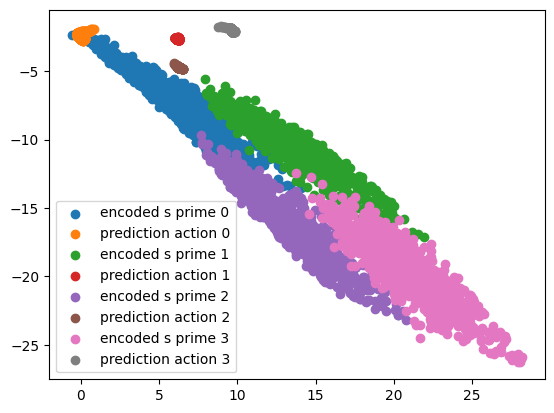

In [158]:
# Evaluate
# Evaluate
def plot_z_space(data):
    with torch.no_grad():
        for i in range(n_actions):
            s = data[i][0][...,:obs_dim]
            a = data[i][0][...,obs_dim:]
            s_prime = data[i][1][..., :obs_dim]
            z = encoder(s)
            z_prime_encoded = encoder(s_prime)
            z_prime = transition_model(torch.cat((z[:, 0:-1], a), dim=-1))
            s_prime = grounding_model(z[:, 0:-1])
            # plt.scatter(z[:, 0], z[:, 1], label=f"encoded action {i}")
            
            plt.scatter(z_prime_encoded[:, 0], z_prime_encoded[:, 1], label=f"encoded s prime {i}")
            plt.scatter(z_prime[:, 0], z_prime[:, 1], label=f"prediction action {i}")
            # plt.scatter(s_prime[:, 0], s_prime[:, 1], label=f"action {i}")
        plt.legend()
        plt.show()

plot_z_space(data)

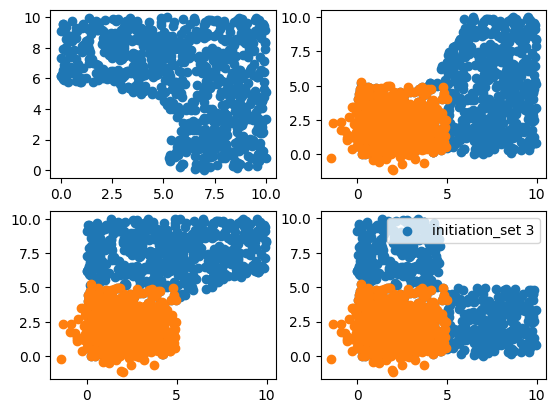

In [154]:
with torch.no_grad():
    x = data[0][0][..., :obs_dim]
    a = data[0][0][...,obs_dim:]
    z = encoder(x)
    logits = initiation_classifier(z[:, :latent_dim])
    z_prime = transition_model(torch.cat((z[:, 0:-1], a), dim=-1))[..., :latent_dim]
    logits_z_prime = initiation_classifier(z_prime)
    init_masks = logits
    for i in range(n_actions):
        plt.subplot(2, 2, i+1)
        plt.scatter(s[init_masks[...,i] > 0.7, 0], s[init_masks[...,i] > 0.7, 1], label=f"initiation_set {i}")
        # plt.scatter(s[data[0][2][...,i] > 0.7, 0], s[data[0][2][...,i] > 0.7, 1], label=f"initiation_set (truth) {i}")
        # plt.scatter(s_prime[0][I_s_prime[i][..., i] == 1, 0], s_prime[0][I_s_prime[i][...,i] == 1, 1])
        plt.scatter(s_prime[0][logits_z_prime[..., i] > 0.7, 0], s_prime[0][logits_z_prime[...,i] > 0.7, 1])

    plt.legend()
    plt.show()

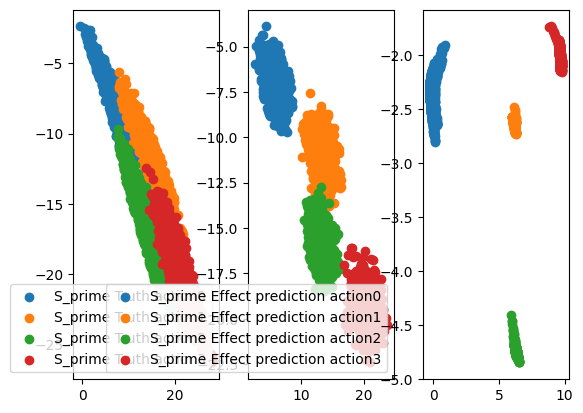

In [159]:
with torch.no_grad():
    for i in range(n_actions):
        
        x = data[i][0][..., :obs_dim]
        a = data[i][0][...,obs_dim:]
        z = encoder(x)
        z_prime_prediction = transition_model(torch.cat((z[:, :latent_dim], a), dim=-1))
        s_prime = grounding_model(z_prime_prediction[..., :latent_dim])

        epsilon = torch.normal(0, 1, (s_prime.size(0), obs_dim))
        s_prime_sample = torch.exp(s_prime[..., obs_dim:]) * epsilon + s_prime[..., :obs_dim]
        z_prime_effect = encoder(s_prime_sample)

        z_prime_truth = encoder(data[i][1][..., :obs_dim])


        logits = initiation_classifier(z[:, :latent_dim])
        plt.subplot(1, 3, 1)
        plt.scatter(z_prime_truth[..., 0], z_prime_truth[..., 1], label=f"S_prime Truth action{i}")
        plt.legend()
        plt.subplot(1, 3, 2)
        plt.scatter(z_prime_effect[..., 0], z_prime_effect[..., 1], label=f"S_prime Effect prediction action{i}")
        plt.legend()
        plt.subplot(1, 3, 3)
        plt.scatter(z_prime_prediction[..., 0], z_prime_prediction[..., 1])
        
    
    plt.show()

In [156]:
# obs_normal = torch.distributions.MultivariateNormal(torch.zeros((obs_dim,)), torch.eye(obs_dim))
# latent_normal = torch.distributions.MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim))
# # Compute next-state marginals

# def next_state_marginal(s_prime, z_prime, n_samples=10):
#     minibatch_size = s_prime.size(0)
#     n_samples_z_marginal = n_samples
#     marginal_z = torch.normal(0, 1, (minibatch_size, n_samples_z_marginal, latent_dim))
#     z_prime_param = transition_model(marginal_z)
#     n_samples_next_z = n_samples
#     z_prime_noise = torch.normal(0, 1, (minibatch_size, n_samples_z_marginal, n_samples_next_z, latent_dim))
#     z_prime_samples = z_prime_noise * torch.exp(z_prime_param.unsqueeze(-2)[..., -2:-1]) + z_prime_param.unsqueeze(-2)[..., 0:-1]
#     grounding_params = grounding_model(z_prime_samples)

#     next_s_marginal = (grounding_params[...,0:-1] - s_prime.unsqueeze(1).unsqueeze(1))/ torch.exp(grounding_params[...,-2:-1])
#     next_z_marginal = (z_prime_param[...,0:-1] - z_prime)/torch.exp(z_prime_param[..., -2:-1])

#     return obs_normal.log_prob(next_s_marginal).mean(1).mean(1), latent_normal.log_prob(next_z_marginal).mean(1)

# def backward_loss(inp, target, predicted_z_prime, s_prime_params, n_samples=10):
#     next_s, next_z = next_state_marginal(target, predicted_z_prime)
#     z_prime_params = encoder(torch.cat((target, inp[..., obs_dim:]), dim=1))
#     # print(predicted_z_prime.shape)
#     # print(z_prime_params.shape)
#     encoder_log_prob = latent_normal.log_prob((predicted_z_prime - z_prime_params[..., :-1])/torch.exp(z_prime_params[..., -2:-1]))
#     # print(encoder_log_prob.shape)
#     grounding_log_prob = obs_normal.log_prob((target - s_prime_params[..., :-1])/torch.exp(s_prime_params[..., -2:-1]))
#     #print(f"Encoder: {encoder_log_prob}, Decoder: {grounding_log_prob}")
#     # print(f"marginal_z: {next_z}, marginal_s: {next_s}")

#     return grounding_log_prob + next_z - next_s-encoder_log_prob

#     #return torch.exp(encoder_log_prob + next_s) - torch.exp(grounding_log_prob + next_z)


# backward_constant = 10

# def forward_backward_loss(inp, target, predicted_s_prime, predicted_z, predicted_z_prime, s_prime):
#     _forward = forward_loss(inp, target, predicted_s_prime, predicted_z, predicted_z_prime, s_prime) 
#     _backward = backward_loss(inp, target, predicted_z_prime, s_prime) ** 2
#     # print(backward_constant * _backward.mean())
#     return  _forward + backward_constant * _backward


# # Evaluate Backward Loss

# z = encoder(data[0][0][:10])
# z_prime = transition_model(z[..., :latent_dim])
# s_prime = grounding_model(z_prime[..., :latent_dim])

# _backward_loss = backward_loss(data[0][0][:10], data[0][1][:10], z_prime[...,:latent_dim], s_prime)
# print(_backward_loss.mean())

# lr = 1e-5
# optimizer = torch.optim.Adam(models_params, lr=lr)
# # encoder, transition_model, grounding_model = init_models()
# training_loop(in_data, out_data, n_epochs, optimizer, loss_fn=forward_backward_loss, print_loss=True)
# plot_z_space(data)
# with torch.no_grad():
#     for i in range(n_actions):
#         s = data[i][0][...,:obs_dim]
#         a = data[i][0][...,obs_dim:]
#         z = encoder(s)
#         z_prime_prediction = transition_model(torch.cat((z[:, 0:-1], a), dim=-1))
#         z_prime = encoder(data[i][1])
        
#         # plt.scatter(z[:, 0], z[:, 1], label=f"s encoding action {i}")
#         plt.scatter(z_prime[:, 0], z_prime[:, 1], label=f"s' encoding action {i}")
#         plt.scatter(z_prime_prediction[:, 0], z_prime_prediction[:, 1], label=f"s' prediction action {i}")
#         # plt.scatter(s_prime[:, 0], s_prime[:, 1], label=f"action {i}")
#     plt.legend()
#     plt.show()
